<a href="https://colab.research.google.com/github/lshin914/CSCI-4364-Final-Project/blob/branch1/Leukemia_CNN_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
from keras import regularizers
from keras.applications import VGG19
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, BatchNormalization
from keras.optimizers import Adam
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

In [6]:
# training data filepaths

all_0 = os.getcwd() + "/drive/MyDrive/ML_Project/C-NMC_Leukemia/training_data/fold_0/all"
hem_0 = os.getcwd() + "/drive/MyDrive/ML_Project/C-NMC_Leukemia/training_data/fold_0/hem"
all_1 = os.getcwd() + "/drive/MyDrive/ML_Project/C-NMC_Leukemia/training_data/fold_1/all"
hem_1 = os.getcwd() + "/drive/MyDrive/ML_Project/C-NMC_Leukemia/training_data/fold_1/hem"
all_2 = os.getcwd() + "/drive/MyDrive/ML_Project/C-NMC_Leukemia/training_data/fold_2/all"
hem_2 = os.getcwd() + "/drive/MyDrive/ML_Project/C-NMC_Leukemia/training_data/fold_2/hem"

print(all_0)

/content/drive/MyDrive/ML_Project/C-NMC_Leukemia/training_data/fold_0/all


In [7]:
# get the path of the valiation data (images and csv file)

# image file folder path
val_path = os.getcwd() + "/drive/MyDrive/ML_Project/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data"

# csv file path
val_labels_path = os.getcwd() + "/drive/MyDrive/ML_Project/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data_labels.csv"

# read the csv file
val_labels = pd.read_csv(val_labels_path)
val_labels.head()

,Patient_ID,new_names,labels
0,UID_57_29_1_all.bmp,1.bmp,1
1,UID_57_22_2_all.bmp,2.bmp,1
2,UID_57_31_3_all.bmp,3.bmp,1
3,UID_H49_35_1_hem.bmp,4.bmp,0
4,UID_58_6_13_all.bmp,5.bmp,1


In [8]:
# function to store image paths in a list
def get_path_image(folder):
    image_paths = []
    image_fnames = os.listdir(folder)
    for img_id in range(len(image_fnames)):
        img = os.path.join(folder,image_fnames[img_id])
        image_paths.append(img)

    return image_paths

In [9]:
# Merge the image file and csv file into one dataset

# get the list of the validation image paths
val_image = get_path_image(val_path)

# get the list of the names of the images (image id)
image_name = os.listdir(val_path)

# create a dataframe from the image paths and the image name (image id)
val_df = pd.DataFrame({'img_data': val_image, 'new_names': image_name})

# merge the image data and the csv data into one file using the unique image_id (image_id is called new_names, column name)
val_df = pd.merge(val_df, val_labels, on='new_names', how='inner')

val_df.head() # validation dataset

,img_data,new_names,Patient_ID,labels
0,/content/drive/MyDrive/ML_Project/C-NMC_Leukem...,1786.bmp,UID_H31_5_2_hem.bmp,0
1,/content/drive/MyDrive/ML_Project/C-NMC_Leukem...,181.bmp,UID_H31_6_1_hem.bmp,0
2,/content/drive/MyDrive/ML_Project/C-NMC_Leukem...,1798.bmp,UID_H32_4_1_hem.bmp,0
3,/content/drive/MyDrive/ML_Project/C-NMC_Leukem...,1811.bmp,UID_66_29_3_all.bmp,1
4,/content/drive/MyDrive/ML_Project/C-NMC_Leukem...,178.bmp,UID_66_12_6_all.bmp,1


In [10]:
print(val_df.iloc[0,0])

/content/drive/MyDrive/ML_Project/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/1786.bmp


In [11]:
# combine folders into one set of data
img_data = []

# we use the data from folder 0 for now
for i in [all_0, all_1, all_2, hem_0, hem_1, hem_2]:
    paths = get_path_image(i)
    img_data.extend(paths)

print(len(img_data)) # number of training data


10715


In [12]:
# create dataframe of the training data, with labels

data = {"img_data":img_data,
        "labels":[np.nan for x in range(len(img_data))]}

df = pd.DataFrame(data)

'''
# For just the first folder
df["labels"][0:2397] = 1 # ALL
df["labels"][2397:3527] = 0 # HEM
'''

# For all three folders
df["labels"][0:7272] = 1 # ALL
df["labels"][7272:10661] = 0 # HEM
df["labels"].fillna(0, inplace = True)
df["labels"] = df["labels"].astype("int64")

<ipython-input-12-cbfdea923114>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["labels"][0:7272] = 1 # ALL
<ipython-input-12-cbfdea923114>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["labels"][7272:10661] = 0 # HEM


In [13]:
df.head()

,img_data,labels
0,/content/drive/MyDrive/ML_Project/C-NMC_Leukem...,1
1,/content/drive/MyDrive/ML_Project/C-NMC_Leukem...,1
2,/content/drive/MyDrive/ML_Project/C-NMC_Leukem...,1
3,/content/drive/MyDrive/ML_Project/C-NMC_Leukem...,1
4,/content/drive/MyDrive/ML_Project/C-NMC_Leukem...,1


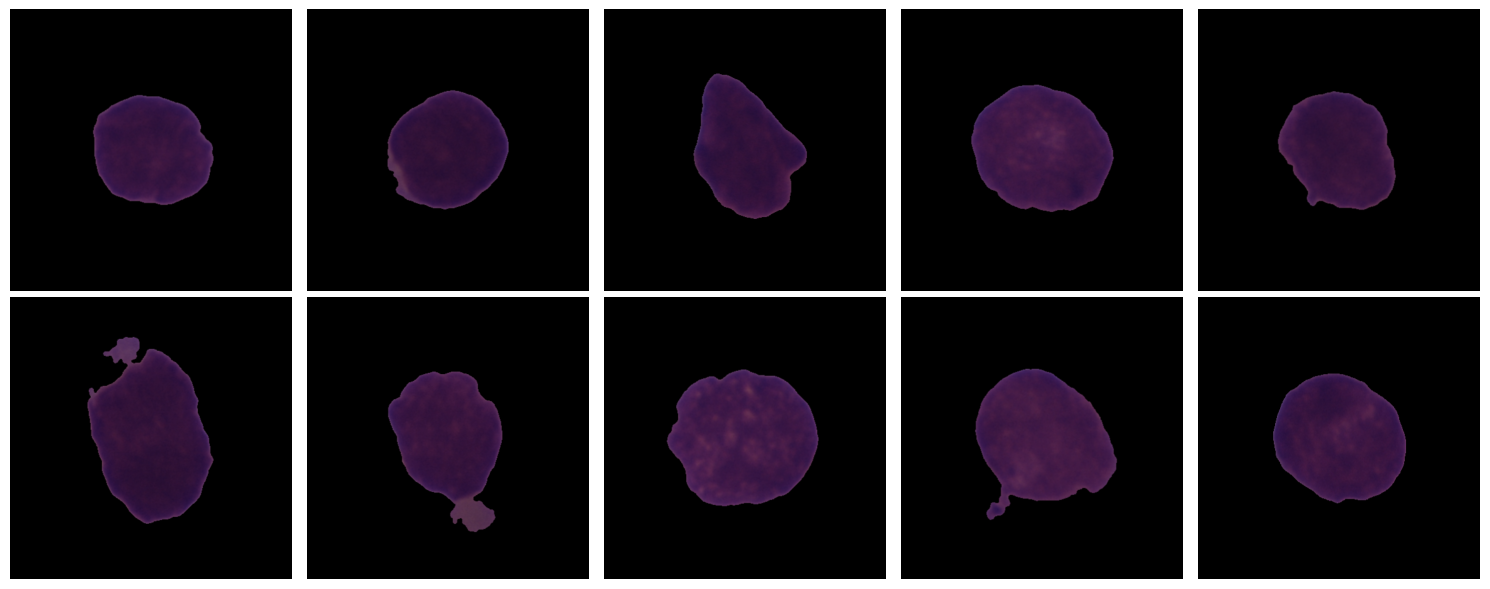

In [14]:
# some images of the cells (cancer cell vs healthy cell)
import matplotlib.image as mpimg
first_10_images = df['img_data'].head(10)

# first 10 images of the cancer cell
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for i, image_path in enumerate(first_10_images):
    img = mpimg.imread(image_path)
    axes[i].imshow(img)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

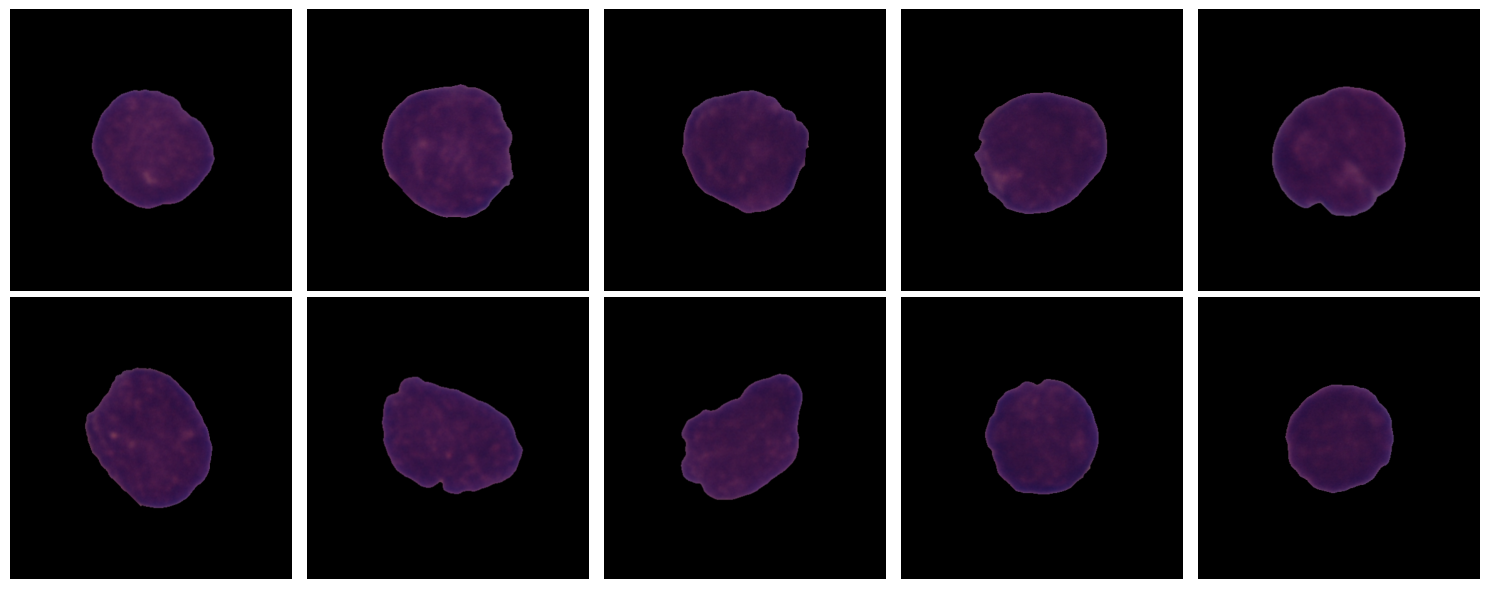

In [15]:
# first 10 images of the healthy cell
starting_row = 1131
first_10_images = df['img_data'].iloc[starting_row:starting_row+10]

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for i, image_path in enumerate(first_10_images):
    img = mpimg.imread(image_path)
    axes[i].imshow(img)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

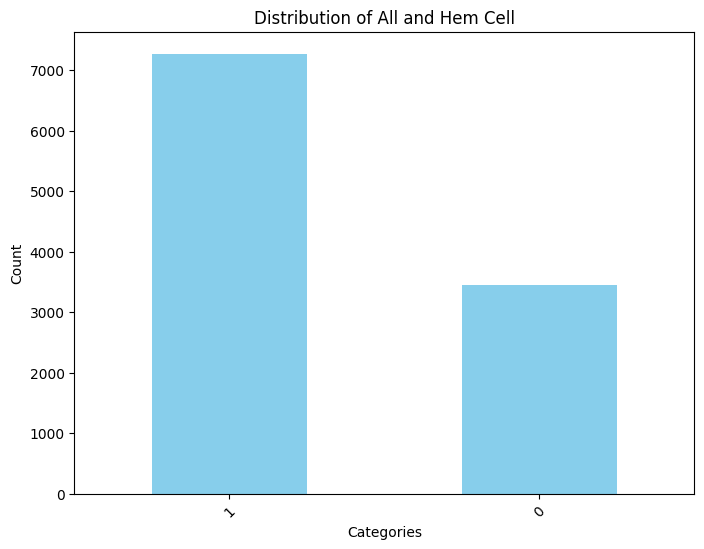

In [16]:
# check if the dataset is balanced or not

target_counts = df["labels"].value_counts()
# create a bar plot
plt.figure(figsize=(8, 6))
target_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of All and Hem Cell')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


In [17]:
'''
# since the size of dataset is large enough, we will use undersampling to handle the imbalanced datasets
print(target_counts)
df = df[1267:]
print(df["labels"].value_counts())
'''

'\n# since the size of dataset is large enough, we will use undersampling to handle the imbalanced datasets\nprint(target_counts)\ndf = df[1267:]\nprint(df["labels"].value_counts())\n'

In [18]:
'''
# the dataset is balanced now (contains 1130 of each category)
plt.figure(figsize=(8, 6))
target_counts = df["labels"].value_counts()
target_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of All and Hem Cell')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()
'''

'\n# the dataset is balanced now (contains 1130 of each category)\nplt.figure(figsize=(8, 6))\ntarget_counts = df["labels"].value_counts()\ntarget_counts.plot(kind=\'bar\', color=\'skyblue\')\nplt.title(\'Distribution of All and Hem Cell\')\nplt.xlabel(\'Categories\')\nplt.ylabel(\'Count\')\nplt.xticks(rotation=45)\nplt.show()\n'

In [19]:
from keras.callbacks import EarlyStopping
earlystop= EarlyStopping(monitor='val_acc', patience=3)

In [20]:
# function to convert the dataframe into image and label, as input for the model

def load_and_preprocess_images(df, target_size=(224, 224)):
    images = []
    labels = []

    for index, row in df.iterrows():
        # load image using OpenCV
        image = cv2.imread(row['img_data'])
        # resize image to target size
        image = cv2.resize(image, target_size)
        # normalize pixel values
        image = image.astype('float32') / 255.0
        images.append(image)
        labels.append(row['labels'])

    return np.array(images), np.array(labels)

In [21]:
# build the VGG19 model
# Regularization techniques added to reduce validation loss:
  # - Second dropout layer is added
  # - L2 Regularization
  # - Early Stop
  # - Batch Normalization

def build_vgg19_model(input_shape, num_classes):
    vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)
    model = Sequential()
    model.add(vgg19)
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001)
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(512, kernel_regularizer=regularizers.l2(0.01), activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    model.layers[0].trainable = False
    return model

In [22]:
def plot_training(hist):
    '''
    This function takes training model and plots history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

80134624/80134624 [==============================] - 0s 0us/step
Epoch 1/10
335/335 [==============================] - ETA: 0s - loss: 1.1989 - accuracy: 0.7774

335/335 [==============================] - 58s 147ms/step - loss: 1.1989 - accuracy: 0.7774 - val_loss: 0.8048 - val_accuracy: 0.6808
Epoch 2/10
335/335 [==============================] - ETA: 0s - loss: 0.5342 - accuracy: 0.7893

335/335 [==============================] - 42s 126ms/step - loss: 0.5342 - accuracy: 0.7893 - val_loss: 0.6922 - val_accuracy: 0.6851
Epoch 3/10
335/335 [==============================] - ETA: 0s - loss: 0.5256 - accuracy: 0.7725

335/335 [==============================] - 42s 127ms/step - loss: 0.5256 - accuracy: 0.7725 - val_loss: 0.7323 - val_accuracy: 0.6535
Epoch 4/10
335/335 [==============================] - ETA: 0s - loss: 0.5265 - accuracy: 0.7730

335/335 [==============================] - 43s 128ms/step - loss: 0.5265 - accuracy: 0.7730 - val_loss: 0.7420 - val_accuracy: 0.6802
Epoch 5/10
335/335 [==============================] - ETA: 0s - loss: 0.5192 - accuracy: 0.7750

335/335 [==============================] - 43s 128ms/step - loss: 0.5192 - accuracy: 0.7750 - val_loss: 0.7140 - val_accuracy: 0.6840
Epoch 6/10
335/335 [==============================] - ETA: 0s - loss: 0.5411 - accuracy: 0.7343

335/335 [==============================] - 43s 128ms/step - loss: 0.5411 - accuracy: 0.7343 - val_loss: 0.6918 - val_accuracy: 0.6551
Epoch 7/10
335/335 [==============================] - ETA: 0s - loss: 0.5248 - accuracy: 0.7724

335/335 [==============================] - 43s 128ms/step - loss: 0.5248 - accuracy: 0.7724 - val_loss: 0.6750 - val_accuracy: 0.6834
Epoch 8/10
335/335 [==============================] - ETA: 0s - loss: 0.5501 - accuracy: 0.7237

335/335 [==============================] - 43s 129ms/step - loss: 0.5501 - accuracy: 0.7237 - val_loss: 0.7709 - val_accuracy: 0.6695
Epoch 9/10
335/335 [==============================] - ETA: 0s - loss: 0.5427 - accuracy: 0.7688

335/335 [==============================] - 43s 129ms/step - loss: 0.5427 - accuracy: 0.7688 - val_loss: 0.7668 - val_accuracy: 0.6738
Epoch 10/10
335/335 [==============================] - ETA: 0s - loss: 0.5391 - accuracy: 0.7742

335/335 [==============================] - 36s 106ms/step - loss: 0.5109 - accuracy: 0.7902
Training Loss: 0.5108916759490967
Training Accuracy: 0.7902006506919861
Validation Loss: 0.8153683543205261
Validation Accuracy: 0.6759507060050964


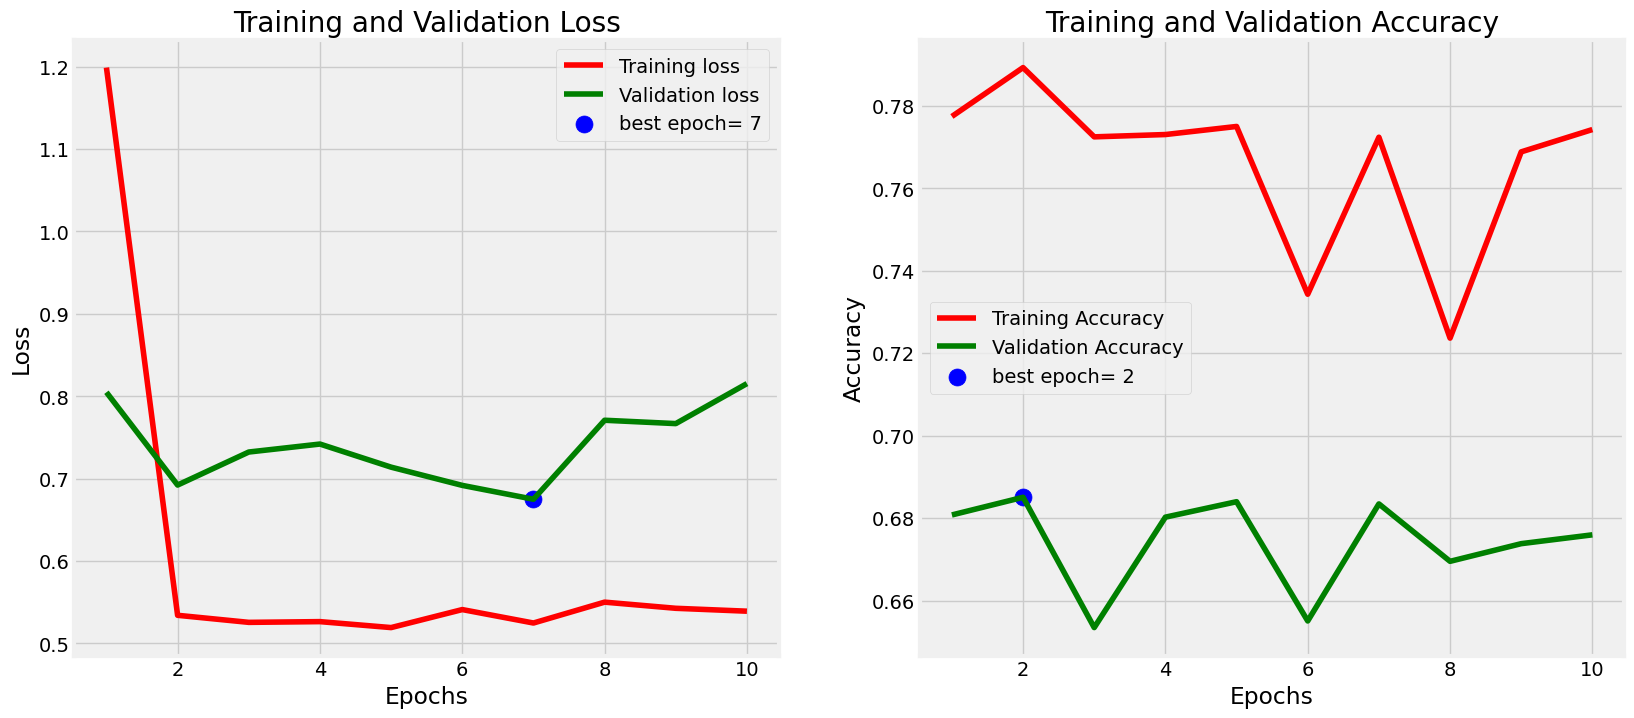

In [23]:
# data preparation (training images and labels)
train_images, train_labels = load_and_preprocess_images(df)

# data preparation (validation images and labels)
validation_images, validation_labels = load_and_preprocess_images(val_df)

# define input shape
input_shape = (224, 224, 3)

# define number of classes
num_classes = 2

# build model
model = build_vgg19_model(input_shape, num_classes)

# compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# train model
history = model.fit(train_images, train_labels, epochs=10, batch_size=32, validation_data=(validation_images, validation_labels), callbacks=[earlystop])

# evaluate model
val_loss, val_accuracy = model.evaluate(validation_images, validation_labels)
train_loss, train_accuracy = model.evaluate(train_images, train_labels)
print("Training Loss:", train_loss)
print("Training Accuracy:", train_accuracy)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Plot training statistics
plot_training(history)


59/59 [==============================] - 6s 101ms/step


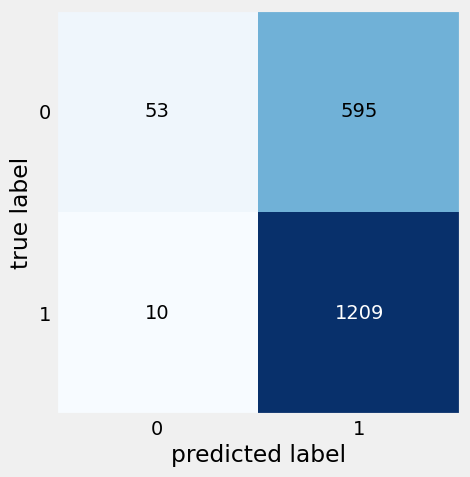

Sensitivity_recall: 0.9917965545529123
Specificity: 0.08179012345679013
Precision: 0.6701773835920177
F1_score: 0.7998676811114787


In [43]:
# Plot confusion matrix
pred = model.predict(validation_images)
pred = np.argmax(pred,axis = 1)
# y_true = np.argmax(validation_labels)
actual = validation_labels
CM = confusion_matrix(actual, pred)
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

Sensitivity_recall = metrics.recall_score(actual, pred)
Specificity = metrics.recall_score(actual, pred, pos_label=0)
Precision = metrics.precision_score(actual, pred)
F1_score = metrics.f1_score(actual, pred)

print("Sensitivity_recall:", Sensitivity_recall)
print("Specificity:", Specificity)
print("Precision:", Precision)
print("F1_score:", F1_score)

In [36]:
print(validation_labels.shape)
print(pred.shape)

(1867,)
(1867,)
